## Using SafeDrone for reliability and safety modelling

SafeDrone is a framework for Reliability/Safety Modelling and Evaluation of Multicopters (Multi-rotor Drones) and Electric powered Vertical TakeOff and Landing (eVTOL) Aircrafts. SafeDrone implement a reliability evaluation approach based on a Markov process.For more information please refer to [this](https://link.springer.com/chapter/10.1007/978-3-030-17771-3_8) work. 

The drone consists of three main electrical components that are essential for its operation.
1. Motor (Rotor)
2. Battery
3. Onboard chip

In the following, we show an example usage of evaluation of reliability for a multi rotor drone system. This is done by predicting the failure probability of the three components.  

In [1]:
import sys
import os

from IPython.display import Markdown as md

from sys import platform

if platform == "linux" or platform == "linux2":
    currentdir = os.path.dirname(os.path.realpath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0, parentdir)
elif platform == "win32":
    # in Windows, the first path entry contains the directory where the notebook is
    sys.path.insert(0, os.path.dirname(sys.path[0]))

from SafeDrones.core.SafeDrones import SafeDrones

In [2]:
eval = SafeDrones()

### 1. Motor Failure risk prediction

To start, let us evaluate the risk of motor failure. For this, we need to provide motor status as input. This can be either "0" for out of order, or "1" for operational. This needs to be provided for all the motors present, as an array. For example, for Quadcopters, the status can be given as any array [1, 0, 0, 1]. Which shows that the 2nd and 3rd motor failure. For our example, let us consider a hexacopter with all operational motors, i.e [1,1,1,1,1,1].

The next required input is motor configuration. This should be given as a string of length equal to the number of motors, made up of 'P' and 'N'. Where 'P' stands for positive rotion, and 'N' for negative rotation. To start with, let us consider a configuration of hexacopter as 'PNPNPN'.

The last two parameters needed are failure rate, and time. Let us consider 0.001 as failure rate and 100 as time. 

In [3]:
P_Fail, MTTF = eval.Motor_Failure_Risk_Calc([1,1,1,1,1,1], 'PNPNPN', 0.001, 100)

print("The probability of failure obtained is: ", P_Fail)

print("The mean time between failure obtained is: ", MTTF)

The probability of failure obtained is:  0.0489641066173940
The mean time between failure obtained is:  483.333333333333


 Now, let us experiments with different configurations and failure statuses, while keeping the failure rate and the time constant. 

In [4]:
P_Fail, MTTF = eval.Motor_Failure_Risk_Calc([0,1,1,1,1,1], 'PNPNPN', 0.001, 100)

print("The probability of failure obtained is: ", P_Fail)

print("The mean time between failure obtained is: ", MTTF)

The probability of failure obtained is:  0.195392392995276
The mean time between failure obtained is:  450.000000000000


In [5]:
P_Fail, MTTF = eval.Motor_Failure_Risk_Calc([0,1,1,0,1,1], 'PNPNPN', 0.001, 100)

print("The probability of failure obtained is: ", P_Fail)

print("The mean time between failure obtained is: ", MTTF)

The probability of failure obtained is:  0.329679953964361
The mean time between failure obtained is:  350.000000000000


In [6]:
P_Fail, MTTF = eval.Motor_Failure_Risk_Calc([1,1,1,1,1,1], 'PPNNPN', 0.001, 100)

print("The probability of failure obtained is: ", P_Fail)

print("The mean time between failure obtained is: ", MTTF)

The probability of failure obtained is:  0.196030818613950
The mean time between failure obtained is:  416.666666666667


We can see that the probability of failure is not only dependent on the failure statuses, but also the configuration. Let us extend our experiments to an Octacopter. 

In [7]:
P_Fail, MTTF = eval.Motor_Failure_Risk_Calc([1,1,1,1,1,1], 'PPNNPPNN', 0.001, 100)

print("The probability of failure obtained is: ", P_Fail)

print("The mean time between failure obtained is: ", MTTF)

The probability of failure obtained is:  0.196030818613950
The mean time between failure obtained is:  452.380952380952


Now let us check how the reliability of a hexa copter changes over time.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [36:07<00:00,  2.17s/it]


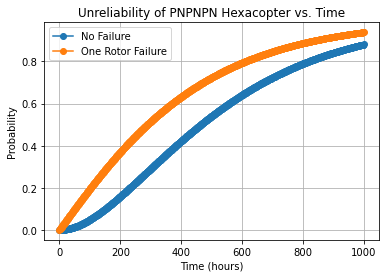

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

P_Fail2 = np.zeros(1000)
P_Fail3 = np.zeros(1000)
MTTF2 = np.zeros(1000)
MTTF3 = np.zeros(1000)

for ii in tqdm(range(1000)):
    P_Fail2[ii], MTTF2[ii] = eval.Motor_Failure_Risk_Calc([1,1,1,1,1,1], 'PNPNPN', 0.001, ii)
    P_Fail3[ii], MTTF3[ii] = eval.Motor_Failure_Risk_Calc([0,1,1,1,1,1], 'PNPNPN', 0.001, ii)

time = list(range(1000))    
plt.plot(time,P_Fail2, label='No Failure',marker='o')
plt.plot(time,P_Fail3, label='One Rotor Failure',marker='o')

plt.xlabel('Time (hours)')
plt.ylabel('Probability')
plt.legend()
plt.title('Unreliability of PNPNPN Hexacopter vs. Time')
plt.grid()
plt.show()

From the graph, it can be seen that the probability of failure with time is always higher for drone operating with one failed rotor. 

### 2. Battery Failure risk prediction

Now, let us use SafeDrone to predict the failure risk of a battery. The failure risk of battery is modelled using morkov mdoel from [this](https://link.springer.com/chapter/10.1007/978-3-030-32872-6_8) work. The input required are battery level, failure rate, etc. Battery level is an integer between 100 and 0, which indicates charge level. The failure rate, battery charge rate alpha, and discharge rate beta, and the battery degradation rate can be used as default. 


In [9]:
P_Fail, MTTF = eval.Battery_Failure_Risk_Calc(80, 100)

print("The probability of battery failure obtained is: ", P_Fail)

print("The mean time between failure for battery obtained is: ", MTTF)

The probability of battery failure obtained is:  0.406254458242660
The mean time between failure for battery obtained is:  451.737451737452


### 3. Chip model Failure risk prediction

Finally, let use predict the failure of chip. Primary source of chip failure is its failure due to temperature. We estimate chip MTTF and failure probability based on dynamic temperature and the time. We use [arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation) to take into account the temperature effect.

For our, example, let us consider a battery with rference MTTF as 400, reference temperature as 30, actual temperature as 50, drone utilisation u as 1 (full utilisation), beta constant describing weibull failure distribution as 1 (constant random failure with time), and time as 100.

In [10]:
P_Fail, MTTF= eval.Chip_MTTF_Model(400, 30, 50, 1, 1,100)

print("The probability of chip failure obtained is: ", P_Fail)

print("The mean time between failure for chip obtained is: ", MTTF)

The probability of chip failure obtained is:  0.234962513468844
The mean time between failure for chip obtained is:  373.370548822240


Now, let us obtain the drone failure probability by combining all three failure modes. (Assuming default values)

In [11]:
P_Fail, MTTF = eval.Drone_Risk_Calc()

print("The probability of overall drone failure obtained is: ", P_Fail)

print("The mean time between failure for complete drone is: ", MTTF)

The probability of overall drone failure obtained is:  0.568003741219376
The mean time between failure for complete drone is:  373.370548822240


Hence, by obtaining the probability of failure for three main components of a drone, we conclude the prediction of proability of failure for a drone. 